In [ ]:
import os
import shutil
import pandas as pd
import re
import pydicom
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import nibabel as nib



In [ ]:


patients_root = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN"

empty_patients = []

for patient_name in sorted(os.listdir(patients_root)):
    patient_path = os.path.join(patients_root, patient_name)
    if not os.path.isdir(patient_path):
        continue

    # Check if folder is empty
    if not os.listdir(patient_path):  # returns [] if empty
        empty_patients.append(patient_name)

# Report
print(f"Total empty patient folders: {len(empty_patients)}")
if empty_patients:
    print("Empty patient folders:")
    for p in empty_patients:
        print(" -", p)


Total empty patient folders: 1
Empty patient folders:
 - 111111


In [ ]:
# Find patients (Subject ID) with more than one unique Study Date in CRF_FORM.csv


root = r"C:/Thesis/Master_thesis_Exploration_---_20250528_210631"
csv_path = os.path.join(root, 'CRF_FORM.csv')

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CRF CSV not found at: {csv_path}")

# Read CSV, keep as strings to avoid parsing surprises
df = pd.read_csv(csv_path, dtype=str)
# Normalize column names
df.columns = [c.strip() for c in df.columns]


subject_col = "Subject ID"
studydate_col = "Study Date"


print('Using Subject column:', subject_col)
print('Using Study Date column:', studydate_col)

# Clean study date and parse to datetime where possible
df[studydate_col] = df[studydate_col].astype(str).str.strip()
# Treat empty strings as NaN
df.loc[df[studydate_col].str.len() == 0, studydate_col] = pd.NA
# Parse dates (many formats); coerce errors to NaT
df['_study_dt_parsed'] = pd.to_datetime(df[studydate_col], errors='coerce')

# Count unique valid study dates per subject
counts = df.dropna(subset=['_study_dt_parsed']).groupby(subject_col)['_study_dt_parsed'].nunique()
# Subjects with more than one unique study date
multi_subjects = counts[counts > 1].index.tolist()

print(f'Found {len(multi_subjects)} subjects with >1 unique Study Date.')

# Filter original rows for these subjects (keep all rows including those with unparsable dates)
if multi_subjects:
    df_multi = df[df[subject_col].isin(multi_subjects)].copy()
    # Optional: sort
    df_multi.sort_values([subject_col, '_study_dt_parsed'], inplace=True, na_position='last')
    # Save to CSV
    out_csv = os.path.join(root, 'CRF_subjects_multiple_studydates.csv')
    df_multi.to_csv(out_csv, index=False)
    print('Saved filtered rows to:', out_csv)
    # Show a small sample
    from IPython.display import display
    display(df_multi.head(50))
else:
    print('No subjects found with more than one Study Date.')

print('\nDone.')


Using Subject column: Subject ID
Using Study Date column: Study Date
Found 71 subjects with >1 unique Study Date.
Saved filtered rows to: C:/Thesis/Master_thesis_Exploration_---_20250528_210631\CRF_subjects_multiple_studydates.csv


,Subject ID,Study Date,Research : Study Visit Number,Research : Study Time,Research : Height,Research : Weight,Age,Sex,Ethnicity,Race,...,Cough,Velcro Crackles,Finger Clubbing,Approx. Symptoms start,Week of Approx. Symptoms start,Exacerbation,Approx. Exacerbation date,Week of Approx. Exacerbation date,Change Log,_study_dt_parsed
625,865785,1969-10-06,NaN,15:15,0,0,70.0,Female,No Information,No Information,...,'True',True,False,'1969-10-13',1.0,NaN,NaN,NaN,NaN,1969-10-06
627,865785,1970-11-02,NaN,13:25,0,0,70.0,Female,No Information,No Information,...,'True',True,False,'1969-10-13',-55.0,NaN,NaN,NaN,NaN,1970-11-02
626,865785,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
628,865785,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
621,866380,1969-10-06,NaN,00:00,0,0,70.0,Female,No Information,No Information,...,'False',False,False,NaN,NaN,NaN,NaN,NaN,NaN,1969-10-06
623,866380,1970-11-09,NaN,00:00,0,0,70.0,Female,No Information,No Information,...,'False',False,False,NaN,NaN,NaN,NaN,NaN,NaN,1970-11-09
622,866380,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,'False',True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaT
624,866380,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,'False',True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaT
602,868819,1957-10-21,NaN,14:21,0,0,58.0,Male,No Information,No Information,...,NaN,True,True,'1956-04-02',-81.0,Yes,'1958-01-20',13.0,NaN,1957-10-21
604,868819,1958-10-27,NaN,14:47,0,0,58.0,Male,No Information,No Information,...,NaN,True,True,'1956-04-02',-135.0,Yes,'1958-01-20',-41.0,NaN,1958-10-27



Done.


In [83]:
#Find patients (Subject ID) with more than one unique Study Date in CRF_FORM.csv
# --- Select and clean relevant columns ---
out_df = (
    df_multi[[subject_col, studydate_col]]
    .copy()
    .assign(**{
        studydate_col: lambda d: d[studydate_col].astype(str).str.strip()
    })
)

# --- Remove empty or missing dates ---
out_df = out_df[out_df[studydate_col].notna() & (out_df[studydate_col] != "")]

# --- Parse to datetime, drop invalid, and format as ISO ---
out_df[studydate_col] = pd.to_datetime(out_df[studydate_col], errors="coerce")
out_df = out_df.dropna(subset=[studydate_col])
out_df[studydate_col] = out_df[studydate_col].dt.strftime("%Y-%m-%d")

out_df


,Subject ID,Study Date
625,865785,1969-10-06
627,865785,1970-11-02
621,866380,1969-10-06
623,866380,1970-11-09
602,868819,1957-10-21
...,...,...
22,928986,1971-11-01
8,929582,1970-10-05
6,929582,1971-06-14
2,930434,1968-10-07


In [ ]:
# Create DICOM folder structure based on Subject IDs in out_df


# --- Validate prerequisites ---
if 'out_df' not in globals():
    raise RuntimeError("out_df not found. Run the previous cell that produced the cleaned SubjectID/StudyDate table first.")

if 'root' not in globals():
    root = r"C:/Thesis/Master_thesis_Exploration_---_20250528_210631"

# --- Detect subject column ---
subject_col_local = next((c for c in out_df.columns if 'subject' in c.lower()), out_df.columns[0])

# --- Normalize subject IDs ---
def normalize_subject_id(s):
    """Strip, remove trailing .0, and return None for NaN."""
    if pd.isna(s):
        return None
    s = str(s).strip()
    return s.split(".")[0] if re.fullmatch(r"\d+\.0", s) else s

subjects = [normalize_subject_id(x) for x in out_df[subject_col_local].unique()]
subjects = [s for s in subjects if s]

# --- Prepare output directory ---
out_root = os.path.join(root, "PATIENTS_DICOM_STRUCTURE")
os.makedirs(out_root, exist_ok=True)

# --- Map top-level directories (excluding destination) ---
top_dirs = {
    name: os.path.join(root, name)
    for name in os.listdir(root)
    if os.path.isdir(os.path.join(root, name)) and name != os.path.basename(out_root)
}

# --- Windows long path helper ---
def win_long_path(path):
    """Add Windows long path prefix if needed."""
    if os.name == 'nt':
        path = os.path.abspath(path)
        if not path.startswith('\\\\?\\'):
            path = '\\\\?\\' + path
    return path

# --- Find matching directories for a subject ---
def find_subject_dirs(subj):
    """Return a list of directories matching the subject ID."""
    matches = []

    # Exact top-level match
    if subj in top_dirs:
        matches.append(top_dirs[subj])
    else:
        # Partial matches in top-level
        for name, path in top_dirs.items():
            if subj == name or subj in name or name.startswith(subj) or name.endswith(subj):
                matches.append(path)

    # Fallback: search one level deeper
    if not matches:
        for _, path in top_dirs.items():
            try:
                for child in os.listdir(path):
                    child_path = os.path.join(path, child)
                    if os.path.isdir(child_path) and (
                        subj == child or subj in child or child.startswith(subj)
                    ):
                        matches.append(child_path)
            except Exception:
                continue

    return matches

# --- Copy directories ---
report = []

for subj in subjects:
    found_dirs = find_subject_dirs(subj)

    if not found_dirs:
        report.append({'SubjectID': subj, 'SrcPath': None, 'DstPath': None, 'Status': 'NotFound'})
        continue

    for i, src in enumerate(found_dirs, start=1):
        dst_name = subj if len(found_dirs) == 1 else f"{subj}_{i}"
        dst = os.path.join(out_root, dst_name)

        if os.path.exists(dst):
            report.append({'SubjectID': subj, 'SrcPath': src, 'DstPath': dst, 'Status': 'ExistsSkipped'})
            continue

        try:
            shutil.copytree(win_long_path(src), win_long_path(dst))
            print(f"Copied {src} → {dst}")
            report.append({'SubjectID': subj, 'SrcPath': src, 'DstPath': dst, 'Status': 'Copied'})
        except Exception as e:
            print(f"copytree failed for {src}, trying manual copy: {e}")
            try:
                os.makedirs(dst, exist_ok=True)
                for root_dir, _, files in os.walk(src):
                    rel_path = os.path.relpath(root_dir, src)
                    target_dir = os.path.join(dst, rel_path)
                    os.makedirs(target_dir, exist_ok=True)
                    for file in files:
                        shutil.copy2(
                            win_long_path(os.path.join(root_dir, file)),
                            win_long_path(os.path.join(target_dir, file))
                        )
                print(f"Manually copied {src} → {dst}")
                report.append({'SubjectID': subj, 'SrcPath': src, 'DstPath': dst, 'Status': 'CopiedManual'})
            except Exception as e2:
                print(f"Manual copy failed for {src}: {e2}")
                report.append({'SubjectID': subj, 'SrcPath': src, 'DstPath': dst, 'Status': f'Error: {e2}'})

# --- Build in-memory report ---
report_df = pd.DataFrame(report)
report_df


Copied C:/Thesis/Master_thesis_Exploration_---_20250528_210631\865785 → C:/Thesis/Master_thesis_Exploration_---_20250528_210631\PATIENTS_DICOM_STRUCTURE\865785
Copied C:/Thesis/Master_thesis_Exploration_---_20250528_210631\866380 → C:/Thesis/Master_thesis_Exploration_---_20250528_210631\PATIENTS_DICOM_STRUCTURE\866380
Copied C:/Thesis/Master_thesis_Exploration_---_20250528_210631\868819 → C:/Thesis/Master_thesis_Exploration_---_20250528_210631\PATIENTS_DICOM_STRUCTURE\868819
Copied C:/Thesis/Master_thesis_Exploration_---_20250528_210631\869718 → C:/Thesis/Master_thesis_Exploration_---_20250528_210631\PATIENTS_DICOM_STRUCTURE\869718
Copied C:/Thesis/Master_thesis_Exploration_---_20250528_210631\870492 → C:/Thesis/Master_thesis_Exploration_---_20250528_210631\PATIENTS_DICOM_STRUCTURE\870492
Copied C:/Thesis/Master_thesis_Exploration_---_20250528_210631\871015 → C:/Thesis/Master_thesis_Exploration_---_20250528_210631\PATIENTS_DICOM_STRUCTURE\871015
Copied C:/Thesis/Master_thesis_Explorati

,SubjectID,SrcPath,DstPath,Status
0,865785,C:/Thesis/Master_thesis_Exploration_---_202505...,C:/Thesis/Master_thesis_Exploration_---_202505...,Copied
1,866380,C:/Thesis/Master_thesis_Exploration_---_202505...,C:/Thesis/Master_thesis_Exploration_---_202505...,Copied
2,868819,C:/Thesis/Master_thesis_Exploration_---_202505...,C:/Thesis/Master_thesis_Exploration_---_202505...,Copied
3,869718,C:/Thesis/Master_thesis_Exploration_---_202505...,C:/Thesis/Master_thesis_Exploration_---_202505...,Copied
4,870492,C:/Thesis/Master_thesis_Exploration_---_202505...,C:/Thesis/Master_thesis_Exploration_---_202505...,Copied
...,...,...,...,...
66,928281,C:/Thesis/Master_thesis_Exploration_---_202505...,C:/Thesis/Master_thesis_Exploration_---_202505...,Copied
67,928687,C:/Thesis/Master_thesis_Exploration_---_202505...,C:/Thesis/Master_thesis_Exploration_---_202505...,Copied
68,928986,C:/Thesis/Master_thesis_Exploration_---_202505...,C:/Thesis/Master_thesis_Exploration_---_202505...,Copied
69,929582,C:/Thesis/Master_thesis_Exploration_---_202505...,C:/Thesis/Master_thesis_Exploration_---_202505...,Copied


In [33]:
Root = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN"
import os

# Count only directories (ignore files)
folder_count = sum(
    1 for entry in os.scandir(Root) if entry.is_dir()
)

print(f"Number of folders in {Root}: {folder_count}")


Number of folders in /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN: 686


In [ ]:
#create the baseline and followup folders based on acquisition date in DICOM_info.csv files


# --- configure ---
try:
    root  # noqa: F821
except NameError:
    root = r"C:/Thesis/Master_thesis_Exploration_---_20250528_210631"

patients_root = os.path.join(root, "PATIENTS_DICOM_STRUCTURE")
if not os.path.isdir(patients_root):
    raise FileNotFoundError(f"PATIENTS_DICOM_STRUCTURE not found at: {patients_root}")

# helper to add Windows long path prefix
def win_long_path(path):
    if os.name == 'nt':
        path = os.path.abspath(path)
        if not path.startswith('\\\\?\\'):
            path = '\\\\?\\' + path
    return path

def _find_acq_date_col(cols):
    cols_l = [c.lower() for c in cols]
    for candidate in (
        "acquisition date", "acq date", "acquisition_date", "acq_date",
        "acquisitiondate", "acqdate", "date"
    ):
        for i, c in enumerate(cols_l):
            if candidate in c:
                return cols[i]
    for i, c in enumerate(cols_l):
        if "acquis" in c and "date" in c:
            return cols[i]
    return None

report_rows = []
removed_folders = 0
patients = ["111522", "116111", "122425", "133692", "252351", "273452", "282770", "311927"]
for patient_name in patients:
    patient_path = os.path.join(patients_root, patient_name)
    if not os.path.isdir(patient_path):
        continue

    # find all DICOM_info.csv files under this patient folder (recursive)
    dicom_info_files = []
    for root_dir, _, files in os.walk(patient_path):
        for fn in files:
            if fn.lower() == "dicom_info.csv" or fn.lower().endswith("dicom_info.csv"):
                dicom_info_files.append(os.path.join(root_dir, fn))

    if not dicom_info_files:
        report_rows.append({
            "PatientFolder": patient_name,
            "Status": "NoDICOMInfoFound",
            "Details": None
        })
        continue

    rows = []
    for csv_path in dicom_info_files:
        try:
            df_csv = pd.read_csv(csv_path, dtype=str)
        except Exception as e:
            report_rows.append({
                "PatientFolder": patient_name,
                "Status": "CSVReadError",
                "Details": f"{csv_path} | {e}"
            })
            continue

        acq_col = _find_acq_date_col(df_csv.columns)
        if acq_col is None:
            report_rows.append({
                "PatientFolder": patient_name,
                "Status": "NoAcqDateColumn",
                "Details": csv_path
            })
            continue

        for idx, val in df_csv[acq_col].astype(str).astype(object).items():
            raw_date = val if pd.notna(val) else None
            series_src = os.path.dirname(csv_path)
            parsed = pd.to_datetime(raw_date, errors="coerce")
            rows.append({
                "PatientFolder": patient_name,
                "CsvPath": csv_path,
                "SeriesSrc": series_src,
                "AcqDateRaw": raw_date,
                "AcqDate": parsed
            })

    valid_rows = [r for r in rows if pd.notna(r["AcqDate"])]
    if not valid_rows:
        report_rows.append({
            "PatientFolder": patient_name,
            "Status": "NoValidAcqDates",
            "Details": len(rows)
        })
        continue

    by_date = {}
    for r in valid_rows:
        date_key = r["AcqDate"].normalize()
        by_date.setdefault(date_key, []).append(r)

    sorted_dates = sorted(by_date.keys())
    baseline_date = sorted_dates[0]

    for date_key in sorted_dates:
        tag = "baseline" if date_key == baseline_date else "followup"
        date_str = pd.to_datetime(date_key).strftime("%Y-%m-%d")
        dest_group_folder = os.path.join(patient_path, f"{tag}_{date_str}")
        os.makedirs(dest_group_folder, exist_ok=True)

        seen_srcs = set()
        for r in by_date[date_key]:
            src = r["SeriesSrc"]
            if src in seen_srcs:
                continue
            seen_srcs.add(src)
            series_name = os.path.basename(src.rstrip(os.sep))
            dst = os.path.join(dest_group_folder, series_name)

            if os.path.exists(dst):
                status = "ExistsSkipped"
            else:
                try:
                    shutil.copytree(win_long_path(src), win_long_path(dst))
                    status = "Copied"
                except Exception:
                    # fallback: manual copy
                    try:
                        os.makedirs(dst, exist_ok=True)
                        for root_dir, _, files in os.walk(src):
                            rel_path = os.path.relpath(root_dir, src)
                            target_dir = os.path.join(dest_group_folder, rel_path)
                            os.makedirs(target_dir, exist_ok=True)
                            for file in files:
                                src_file = os.path.join(root_dir, file)
                                print(src_file)
                                dst_file = os.path.join(target_dir, file)
                                shutil.copy2(win_long_path(src_file), win_long_path(dst_file))
                        status = "CopiedManual"
                    except Exception as e2:
                        status = f"Error:{e2}"

            # ✅ Remove old folder if copy succeeded
            if status in ("Copied", "CopiedManual"):
                try:
                    shutil.rmtree(win_long_path(src))
                    removed_folders += 1
                except Exception as e:
                    print(f"Could not remove {src}: {e}")

            report_rows.append({
                "PatientFolder": patient_name,
                "AcqDate": date_str,
                "Tag": tag,
                "SrcSeries": src,
                "DstSeries": dst,
                "Status": status
            })

# build report DataFrame in-memory and display
report_df = pd.DataFrame(report_rows)
print("Finished. Summary counts:")
print(report_df['Status'].value_counts(dropna=False))
print(f"Removed old folders: {removed_folders}")

from IPython.display import display
display(report_df.head(200))


FileNotFoundError: PATIENTS_DICOM_STRUCTURE not found at: C:/Thesis/Master_thesis_Exploration_---_20250528_210631/PATIENTS_DICOM_STRUCTURE

In [ ]:
#remove intermediate "series instance UID" folder in baseline_* and followup_* directories


flattened_count = 0
errors = []

# Loop through all patients
for patient_name in sorted(os.listdir(patients_root)):
    patient_path = os.path.join(patients_root, patient_name)
    if not os.path.isdir(patient_path):
        continue

    # Look for baseline_* and followup_* folders
    for visit_name in os.listdir(patient_path):
        visit_path = os.path.join(patient_path, visit_name)
        if not os.path.isdir(visit_path):
            continue
        if not (visit_name.lower().startswith("baseline") or visit_name.lower().startswith("followup")):
            continue

        # If visit folder contains exactly one subfolder (the "X" folder)
        subfolders = [f for f in os.listdir(visit_path) if os.path.isdir(os.path.join(visit_path, f))]
        if len(subfolders) == 1:
            x_folder = os.path.join(visit_path, subfolders[0])
            try:
                # Move all contents of X into visit_path
                for item in os.listdir(x_folder):
                    src_item = os.path.join(x_folder, item)
                    dst_item = os.path.join(visit_path, item)

                    # If destination exists, merge or skip
                    if os.path.exists(dst_item):
                        # Merge directories
                        if os.path.isdir(src_item) and os.path.isdir(dst_item):
                            for root_dir, _, files in os.walk(src_item):
                                rel_path = os.path.relpath(root_dir, src_item)
                                target_dir = os.path.join(dst_item, rel_path)
                                os.makedirs(target_dir, exist_ok=True)
                                for file in files:
                                    shutil.move(os.path.join(root_dir, file), os.path.join(target_dir, file))
                        else:
                            print(f"Skipping existing: {dst_item}")
                    else:
                        shutil.move(src_item, dst_item)

                # Remove the now-empty X folder
                shutil.rmtree(x_folder)
                flattened_count += 1
                print(f"Flattened: {x_folder}")
            except Exception as e:
                errors.append((x_folder, str(e)))

print(f"\nFlattened {flattened_count} intermediate folders.")
if errors:
    print("Errors:", errors)


Flattened: C:/Thesis/Master_thesis_Exploration_---_20250528_210631\PATIENTS_DICOM_STRUCTURE\865785\baseline_1969-10-06\b767c0bb-a3bb-4ac7-a123-1e051550fefb
Flattened: C:/Thesis/Master_thesis_Exploration_---_20250528_210631\PATIENTS_DICOM_STRUCTURE\865785\followup_1970-11-02\aef7cec5-97a9-4ff0-87e3-fcdd3c6f2cc2
Flattened: C:/Thesis/Master_thesis_Exploration_---_20250528_210631\PATIENTS_DICOM_STRUCTURE\866380\baseline_1969-10-06\2ce51dd1-084f-4509-b5be-d96d98513d8e
Flattened: C:/Thesis/Master_thesis_Exploration_---_20250528_210631\PATIENTS_DICOM_STRUCTURE\866380\followup_1970-11-09\111687a3-a64d-4d0b-93f9-df9e252d14c1
Flattened: C:/Thesis/Master_thesis_Exploration_---_20250528_210631\PATIENTS_DICOM_STRUCTURE\868819\baseline_1957-10-21\01fc3fdb-8f24-4f7b-9293-b0a82f8f9fec
Flattened: C:/Thesis/Master_thesis_Exploration_---_20250528_210631\PATIENTS_DICOM_STRUCTURE\868819\followup_1958-10-27\9a406fde-f7d1-4689-8294-985dfa1846b2
Flattened: C:/Thesis/Master_thesis_Exploration_---_20250528_2106

In [ ]:
#remove intermediate AXIAL, LOCALIZER, dicom etc. folders in baseline_* and followup_* directories(mistake)
def flatten_single_subfolder(path):
    """
    If a folder contains exactly one subfolder, move its contents up and remove it.
    Repeat until no single-subfolder chain remains.
    """
    while True:
        items = os.listdir(path)
        subfolders = [f for f in items if os.path.isdir(os.path.join(path, f))]
        files = [f for f in items if os.path.isfile(os.path.join(path, f))]

        # Stop if there are files or more than one subfolder
        if files or len(subfolders) != 1:
            break

        only_sub = os.path.join(path, subfolders[0])
        # Move everything from the only subfolder up
        for item in os.listdir(only_sub):
            shutil.move(os.path.join(only_sub, item), os.path.join(path, item))
        os.rmdir(only_sub)  # remove the now-empty folder

def flatten_all(root):
    for dirpath, dirnames, filenames in os.walk(root, topdown=False):
        flatten_single_subfolder(dirpath)

# Run flattening
flatten_all(patients_root)
print("Flattening complete.")


Flattening complete.


In [ ]:
#score and keep the best DICOM series in each baseline_* and followup_* folder, remove the others




# ------------------ Scoring Function ------------------ #
def calculate_series_score(series_path):
    """Calculate a combined score for a DICOM series folder."""
    dcm_files = [f for f in os.listdir(series_path) if f.lower().endswith(".dcm")]
    if not dcm_files:
        return None

    slice_positions = []
    pixel_spacings = []
    valid_files = 0
    modality = None
    slice_thickness = None
    series_desc = None
    recon_kernel = None

    for f in dcm_files:
        try:
            ds = pydicom.dcmread(os.path.join(series_path, f), stop_before_pixels=True)
            valid_files += 1

            if modality is None:
                modality = getattr(ds, "Modality", None)
            if slice_thickness is None:
                try:
                    slice_thickness = float(getattr(ds, "SliceThickness", 0))
                except Exception:
                    slice_thickness = None
            if series_desc is None:
                series_desc = str(getattr(ds, "SeriesDescription", "") or "")
            if recon_kernel is None:
                recon_kernel = str(getattr(ds, "ReconstructionKernel", "") or "")

            if hasattr(ds, "ImagePositionPatient"):
                slice_positions.append(ds.ImagePositionPatient[2])
            if hasattr(ds, "PixelSpacing"):
                try:
                    pixel_spacings.append(float(ds.PixelSpacing[0]))
                except Exception:
                    pass

        except Exception:
            pass

    if valid_files == 0:
        return None

    # --- Numeric scoring ---
    num_slices = valid_files
    spacing_std = np.std(np.diff(sorted(slice_positions))) if len(slice_positions) > 1 else 0
    avg_pixel_spacing = np.mean(pixel_spacings) if pixel_spacings else 1.0
    score_numeric = num_slices * 1.0 - spacing_std * 10.0 - avg_pixel_spacing * 5.0

    # --- Metadata heuristic ---
    info = {
        "modality": modality,
        "files": dcm_files,
        "slice_thickness": slice_thickness,
        "series_desc": series_desc,
        "recon_kernel": recon_kernel
    }
    s_meta = 0
    if (info.get('modality') or '').upper() != 'CT':
        s_meta -= 1000
    s_meta += len(info['files'])
    th = info.get('slice_thickness') or 0
    if 0 < th <= 1.5:
        s_meta += 50
    elif 1.5 < th <= 3:
        s_meta += 20
    desc = (info.get('series_desc') or '').upper() + ' ' + (info.get('recon_kernel') or '').upper()
    if any(k in desc for k in ('LUNG', 'CHEST', 'THORAX')):
        s_meta += 30
    if any(k in desc for k in ('LOCALIZER', 'SCOUT')):
        s_meta -= 100

    return round(score_numeric + s_meta, 2)

# ------------------ Parallel Processing ------------------ #
def process_visit(patient_id, visit):
    """Score all series in a visit and return best one."""
    visit_path = os.path.join(patients_root, patient_id, visit)
    if not os.path.isdir(visit_path):
        return None

    series_folders = [
        f for f in os.listdir(visit_path)
        if os.path.isdir(os.path.join(visit_path, f))
    ]
    if not series_folders:
        return None

    # Score series in parallel
    scores = []
    with ThreadPoolExecutor(max_workers=20) as executor:  # adjust workers as needed
        future_to_series = {
            executor.submit(calculate_series_score, os.path.join(visit_path, sf)): sf
            for sf in series_folders
        }
        for future in as_completed(future_to_series):
            sf = future_to_series[future]
            try:
                score = future.result()
                if score is not None:
                    scores.append((sf, score))
            except Exception as e:
                print(f"Error scoring {sf}: {e}")

    if not scores:
        return None

    # Pick best series
    best_series, best_score = max(scores, key=lambda x: x[1])

    # Remove others
    removed = 0
    for sf, score in scores:
        if sf != best_series:
            try:
                shutil.rmtree(os.path.join(visit_path, sf))
                removed += 1
            except Exception as e:
                print(f"Could not remove {sf}: {e}")

    return {
        "patient": patient_id,
        "visit": visit,
        "kept_series": best_series,
        "score": best_score,
        "removed": removed
    }

# ------------------ Main Loop ------------------ #
results = []
for patient_id in sorted(os.listdir(patients_root)):
    patient_path = os.path.join(patients_root, patient_id)
    if not os.path.isdir(patient_path):
        continue

    for visit in os.listdir(patient_path):
        res = process_visit(patient_id, visit)
        if res:
            results.append(res)

# ------------------ Summary ------------------ #
print("\nSummary:")
for r in results:
    print(f"Patient: {r['patient']}, Visit: {r['visit']}, Kept: {r['kept_series']} (Score: {r['score']}), Removed: {r['removed']}")



Summary:
Patient: 1002403, Visit: baseline_1943-11-01, Kept: 1.2.826.0.1.3680043.10.1218.729860259497164512445128764063934274 (Score: 630.41), Removed: 0
Patient: 1002403, Visit: followup_1948-10-01, Kept: 1.2.826.0.1.3680043.10.1218.103283453286311970533863938790479615 (Score: 1058.44), Removed: 4


In [ ]:
# some folder structure like this way so used this code for flattening the folders for some patients
# patients_root/ ├── Patient001/ │ ├── baseline_YYYY-MM-DD/ │ │ └── <SeriesUID1>/ │ │ └── LOCALIZER └── ...dcm (DICOM slices) │ │ └── OTHER └── ...dcm (DICOM slices) │ │ └── <SeriesUID2>/ │ │ └── LOCALIZER └── ...dcm (DICOM slices) │ │ └── OTHER └── ...dcm (DICOM slices) │ │ └── <SeriesUID3>/ └── ...dcm (DICOM slices) │ │ └── *_NIFTY/*.nii.gz │ │ └── *_Mask/*.nii.gz    




def clean_series_folder(series_path):
    """
    - Delete LOCALIZER folder if present
    - Flatten OTHER folder if present
    """
    for item in os.listdir(series_path):
        item_path = os.path.join(series_path, item)
        if not os.path.isdir(item_path):
            continue

        lname = item.lower()
        if lname == "localizer":
            print(f"Deleting LOCALIZER: {item_path}")
            shutil.rmtree(item_path, ignore_errors=True)

        elif lname == "AXIAL":
            print(f"Flattening OTHER: {item_path}")
            # Move all DICOMs up one level
            for root, _, files in os.walk(item_path):
                for f in files:
                    if f.lower().endswith(".dcm"):
                        src = os.path.join(root, f)
                        dst = os.path.join(series_path, f)
                        # Avoid overwriting
                        if os.path.exists(dst):
                            base, ext = os.path.splitext(f)
                            dst = os.path.join(series_path, f"{base}_moved{ext}")
                        shutil.move(src, dst)
            # Remove the OTHER folder after moving
            shutil.rmtree(item_path, ignore_errors=True)

def clean_patient(patient_path):
    for baseline in os.listdir(patient_path):
        baseline_path = os.path.join(patient_path, baseline)
        if not os.path.isdir(baseline_path):
            continue
        if not baseline.lower().startswith("followup"):
            continue

        for series in os.listdir(baseline_path):
            series_path = os.path.join(baseline_path, series)
            if not os.path.isdir(series_path):
                continue
            # Skip NIFTY and Mask folders
            if series.lower().endswith("nifty") or series.lower().endswith("mask"):
                continue
            clean_series_folder(series_path)

# --- Run for all patients ---
patinet = ['1002403']
patients_root = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN"
for patient_id in sorted(patinet):
    patient_path = os.path.join(patients_root, patient_id)
    if not os.path.isdir(patient_path):
        continue
    print(f"\nProcessing patient: {patient_id}")
    clean_patient(patient_path)

print("\nCleanup complete.")



Processing patient: 1002403

Cleanup complete.


In [15]:
patients_root = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN"
patinet = ['1002403']
for patient_id in patinet:
    patient_path = os.path.join(patients_root, patient_id)
    if not os.path.isdir(patient_path):
        continue

    # Loop through baseline/followup visit folders
    for visit_folder in os.listdir(patient_path):
        visit_path = os.path.join(patient_path, visit_folder)
        if not os.path.isdir(visit_path):
            continue

        # Loop through SeriesUID folders
        for series_folder in os.listdir(visit_path):
            series_path = os.path.join(visit_path, series_folder)
            if not os.path.isdir(series_path):
                continue

            axial_path = os.path.join(series_path, "AXIAL")
            if os.path.isdir(axial_path):
                print(f"Processing {axial_path}...")

                # Move all files from AXIAL to SeriesUID folder
                for fname in os.listdir(axial_path):
                    src = os.path.join(axial_path, fname)
                    dst = os.path.join(series_path, fname)
                    if os.path.isfile(src):
                        # If file already exists, rename to avoid overwrite
                        if os.path.exists(dst):
                            base, ext = os.path.splitext(fname)
                            dst = os.path.join(series_path, f"{base}_moved{ext}")
                        shutil.move(src, dst)

                # Remove the empty AXIAL folder
                try:
                    os.rmdir(axial_path)
                    print(f"Removed empty folder: {axial_path}")
                except OSError as e:
                    print(f"Could not remove {axial_path}: {e}")


Processing /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1002403/followup_1948-10-01/1.2.826.0.1.3680043.10.1218.118918765964347571812018994872462028/AXIAL...
Removed empty folder: /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1002403/followup_1948-10-01/1.2.826.0.1.3680043.10.1218.118918765964347571812018994872462028/AXIAL
Processing /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1002403/followup_1948-10-01/1.2.826.0.1.3680043.10.1218.605110560722530361581269800791271832/AXIAL...
Removed empty folder: /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1002403/followup_1948-10-01/1.2.826.0.1.3680043.10.1218.605110560722530361581269800791271832/AXIAL
Processing /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1002403/followup_1948-10-01/1.2.826.0.1.3680043.10.1218.486387278796655397409438432964991288/AXIAL...
Removed empty folder: /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1002403/followup_1948-10-01/1.2.826.0.1.3680043.10.1218.486387278796655397409438432964991288/AXIAL
Processing

In [ ]:
#count dicom/slices in baseline data for each patients

results = []
i = 1
root = r"/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN"
for patient in os.listdir(root):
    patient_dir = os.path.join(root, patient)
    
    if not os.path.isdir(patient_dir):
        continue

    # find baseline folder
    for baseline in os.listdir(patient_dir):
        if baseline.startswith("baseline_"):
            baseline_dir = os.path.join(patient_dir, baseline)
            

            # find series UID folder (the one starting with "1.")
            series_folders = [f for f in os.listdir(baseline_dir) if f.startswith("1.")]
            
            if not series_folders:
                print(patient)
                continue
            i = i+1
            series_uid = series_folders[0]
            series_path = os.path.join(baseline_dir, series_uid)

            # count DICOM slices
            dicom_files = [f for f in os.listdir(series_path) if f.endswith(".dcm")]
            num_slices = len(dicom_files)

            # parse patient ID and date
            baseline_date = baseline.replace("baseline_", "")
            patient_id = patient.replace("Patient", "")  # or parse from mask filename if needed
            
            results.append({
                "PatientID": patient_id,
                "BaselineDate": baseline_date,
                "SeriesUID": series_uid,
                "NumSlices": num_slices
            })

# Save to CSV
number_of_slices = pd.DataFrame(results)
# number_of_slices.to_csv("patient_slices.csv", index=False)
print(i)
print(number_of_slices.head())
\

num_unique_patients = number_of_slices["PatientID"].nunique()
print("Number of unique patients:", num_unique_patients)

687
  PatientID BaselineDate                                          SeriesUID  \
0   1001326   1971-01-01  1.2.826.0.1.3680043.10.1218.729327262603124254...   
1    298078   1967-10-09  1.2.392.200036.9116.2.6.1.3268.2047398422.1539...   
2    208368   1953-10-26  1.2.840.113619.2.55.3.1024080006.430.151121708...   
3    727988   1970-10-05  1.2.392.200036.9116.2.6.1.3268.2047398422.1581...   
4   1001092   1980-01-01  1.2.826.0.1.3680043.10.1218.114401689482668046...   

   NumSlices  
0        983  
1        396  
2         18  
3        376  
4        290  
Number of unique patients: 686


In [2]:
# # Patients with slice count between 20 and 30 (inclusive)
# find_patients_between_20_30 = number_of_slices[
#     (number_of_slices["NumSlices"] >= 30) & (number_of_slices["NumSlices"] <= 70)
# ]

# print(find_patients_between_20_30)

find_patients_below_30_slices = number_of_slices[number_of_slices["NumSlices"] < 30] 
find_patients_below_30_slices  

# patient_id = "1000699"
# patient_slices = number_of_slices.query("PatientID == @patient_id")
# print(patient_slices)



,PatientID,BaselineDate,SeriesUID,NumSlices
2,208368,1953-10-26,1.2.840.113619.2.55.3.1024080006.430.151121708...,18
6,930446,1973-10-01,1.2.392.200036.9116.2.6.1.3268.2047398422.1499...,20
12,164772,1940-11-11,1.2.840.113619.2.55.3.1024080006.536.139079992...,16
19,927346,1944-11-06,1.2.840.113619.2.55.3.1024080006.109.141712823...,20
21,312980,1963-10-14,1.2.840.113619.2.55.3.1024080006.113.140805618...,20
...,...,...,...,...
667,684240,1954-10-25,1.2.840.113619.2.55.3.1024080006.527.153065811...,18
668,567609,1960-10-17,1.2.840.113619.2.55.3.1024080006.320.142619985...,18
682,196805,1975-09-29,1.2.840.113619.2.55.3.1024080006.220.142257200...,20
684,770462,1966-10-10,1.2.840.113619.2.55.3.1024080006.223.138187583...,16


In [ ]:

# Root folder where all patient folders currently exist
patients_root = "/scratch/bds/OSIC/"

# Target folder
target_root = os.path.join(patients_root, "patients_slices_below_30")

# Create target folder if it doesn't exist
os.makedirs(target_root, exist_ok=True)

# Get list of patient IDs to move (ensure string type)
patient_ids_to_move = find_patients_below_30_slices["PatientID"].astype(str).tolist()
i = 1
for patient_id in patient_ids_to_move:
    src = os.path.join(patients_root, "PATIENTS_DICOM_STRUCTURE_MAIN/", patient_id)
    dst = os.path.join(target_root, patient_id)

    if os.path.isdir(src):
        # If destination already exists, skip or handle as needed
        if os.path.exists(dst):
            print(f"Destination already exists, skipping:{dst}")
            
        else:
            print(f"Moving {src} → {dst}")
            shutil.move(src, dst)
    else:
        print(f"Patient folder not found: {i}.{src}")
        i = i+1
    

❌ Patient folder not found: 1./scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/208368
❌ Patient folder not found: 2./scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/930446
❌ Patient folder not found: 3./scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/164772
❌ Patient folder not found: 4./scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/927346
❌ Patient folder not found: 5./scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/312980
❌ Patient folder not found: 6./scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/363722
❌ Patient folder not found: 7./scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/670120
❌ Patient folder not found: 8./scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/643088
❌ Patient folder not found: 9./scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/963244
❌ Patient folder not found: 10./scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/522735
❌ Patient folder not found: 11./scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/529283
❌ Patient folder not found: 12./scratch/bds/OSIC/PATIENTS_DICOM

In [ ]:


# --- 1. Load all DICOM slices ---
folder = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/201242/baseline_1968-10-07/1.3.6.1.4.1.5962.99.1.1545105759.444655908.1625042776415.7322.0"
files = [pydicom.dcmread(os.path.join(folder, f)) 
         for f in os.listdir(folder) if f.lower().endswith(".dcm")]

# --- 2. Sort slices by Z position ---
files.sort(key=lambda ds: float(ds.ImagePositionPatient[2]))

# --- 3. Stack into a 3D NumPy array ---
volume = np.stack([ds.pixel_array for ds in files])

# --- 4. Extract Z positions in mm ---
z_positions = np.array([float(ds.ImagePositionPatient[2]) for ds in files])

print(f"Available Z range: {z_positions.min():.2f} mm to {z_positions.max():.2f} mm")

# --- 5. Function to show slice at a given position ---
def show_slice_at_position(z_mm):
    # Find index of slice closest to requested position
    idx = (np.abs(z_positions - z_mm)).argmin()
    plt.imshow(volume[idx], cmap="gray")
    plt.title(f"Requested: {z_mm:.2f} mm | Showing slice at: {z_positions[idx]:.2f} mm")
    plt.axis("off")
    plt.show()

# --- 6. Example: manually set position ---
manual_position_mm = 2020  # change this to your desired mm position
show_slice_at_position(manual_position_mm)


TypeError: 'NoneType' object is not subscriptable

Available Z range: 0.00 mm to 511.00 mm


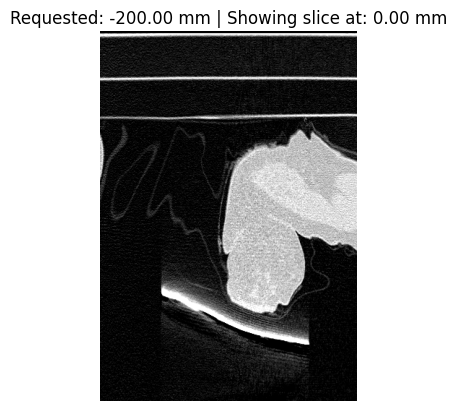

In [ ]:


# --- 1. Load NIfTI file ---
nifti_path = "/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE_MAIN/1001240/baseline_1972-01-01/1001240_baseline_1972-01-01_NIfTY/1001240_baseline_1972-01-01.nii.gz"
img = nib.load(nifti_path)
data = img.get_fdata()  # 3D NumPy array
affine = img.affine     # 4x4 affine matrix

# --- 2. Compute Z positions for each slice ---
nz = data.shape[2]
z_positions = []
for k in range(nz):
    # Convert voxel coordinate (0,0,k) to world coordinate
    x, y, z, _ = affine @ [0, 0, k, 1]
    z_positions.append(z)
z_positions = np.array(z_positions)

print(f"Available Z range: {z_positions.min():.2f} mm to {z_positions.max():.2f} mm")

# --- 3. Function to show slice at a given Z position ---
def show_slice_at_position(z_mm):
    idx = (np.abs(z_positions - z_mm)).argmin()
    plt.imshow(data[:, :, idx].T, cmap="gray", origin="lower")
    plt.title(f"Requested: {z_mm:.2f} mm | Showing slice at: {z_positions[idx]:.2f} mm")
    plt.axis("off")
    plt.show()

# --- 4. Example: manually set position ---
manual_position_mm = -200.0  # change this to your desired mm position
show_slice_at_position(manual_position_mm)


In [ ]:


folder = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/201242/baseline_1968-10-07/1.3.6.1.4.1.5962.99.1.1545105759.444655908.1625042776415.7322.0"

# Read only files that have pixel data
files = []
for f in os.listdir(folder):
    if f.lower().endswith(".dcm"):
        ds = pydicom.dcmread(os.path.join(folder, f))
        if hasattr(ds, "PixelData"):  # skip non-image DICOMs
            files.append(ds)

# Sort slices safely
def sort_key(ds):
    if hasattr(ds, "ImagePositionPatient") and ds.ImagePositionPatient is not None:
        return float(ds.ImagePositionPatient[2])
    elif hasattr(ds, "SliceLocation"):
        return float(ds.SliceLocation)
    else:
        return int(ds.InstanceNumber)  # last fallback

files.sort(key=sort_key)

# Stack into 3D volume
volume = np.stack([ds.pixel_array for ds in files])
print("Volume shape:", volume.shape)


Volume shape: (382, 512, 512)
